# Heliocentric vs. Barycentric Frames

In [ ]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

from astropy.time import Time
from astroquery.jplhorizons import Horizons

from jorbit import Particle
from jorbit.utils.kepler import M_from_f, kepler
from jorbit.utils.states import barycentric_to_heliocentric, heliocentric_to_barycentric

`jorbit` performs all of its integrations in the ICRS barycentric frame. While this behavior makes it convenient to compute astrometric positions, it can cause confusion when comparing with orbital elements provided in a heliocentric frame.

For example, if you look up an asteroid's instantaneous orbital elements on [SBDB](https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/), they will not match those computed by `jorbit`. To demonstrate this, consider the asteroid (1385) Gelria: on SBDB, as of writing we get:

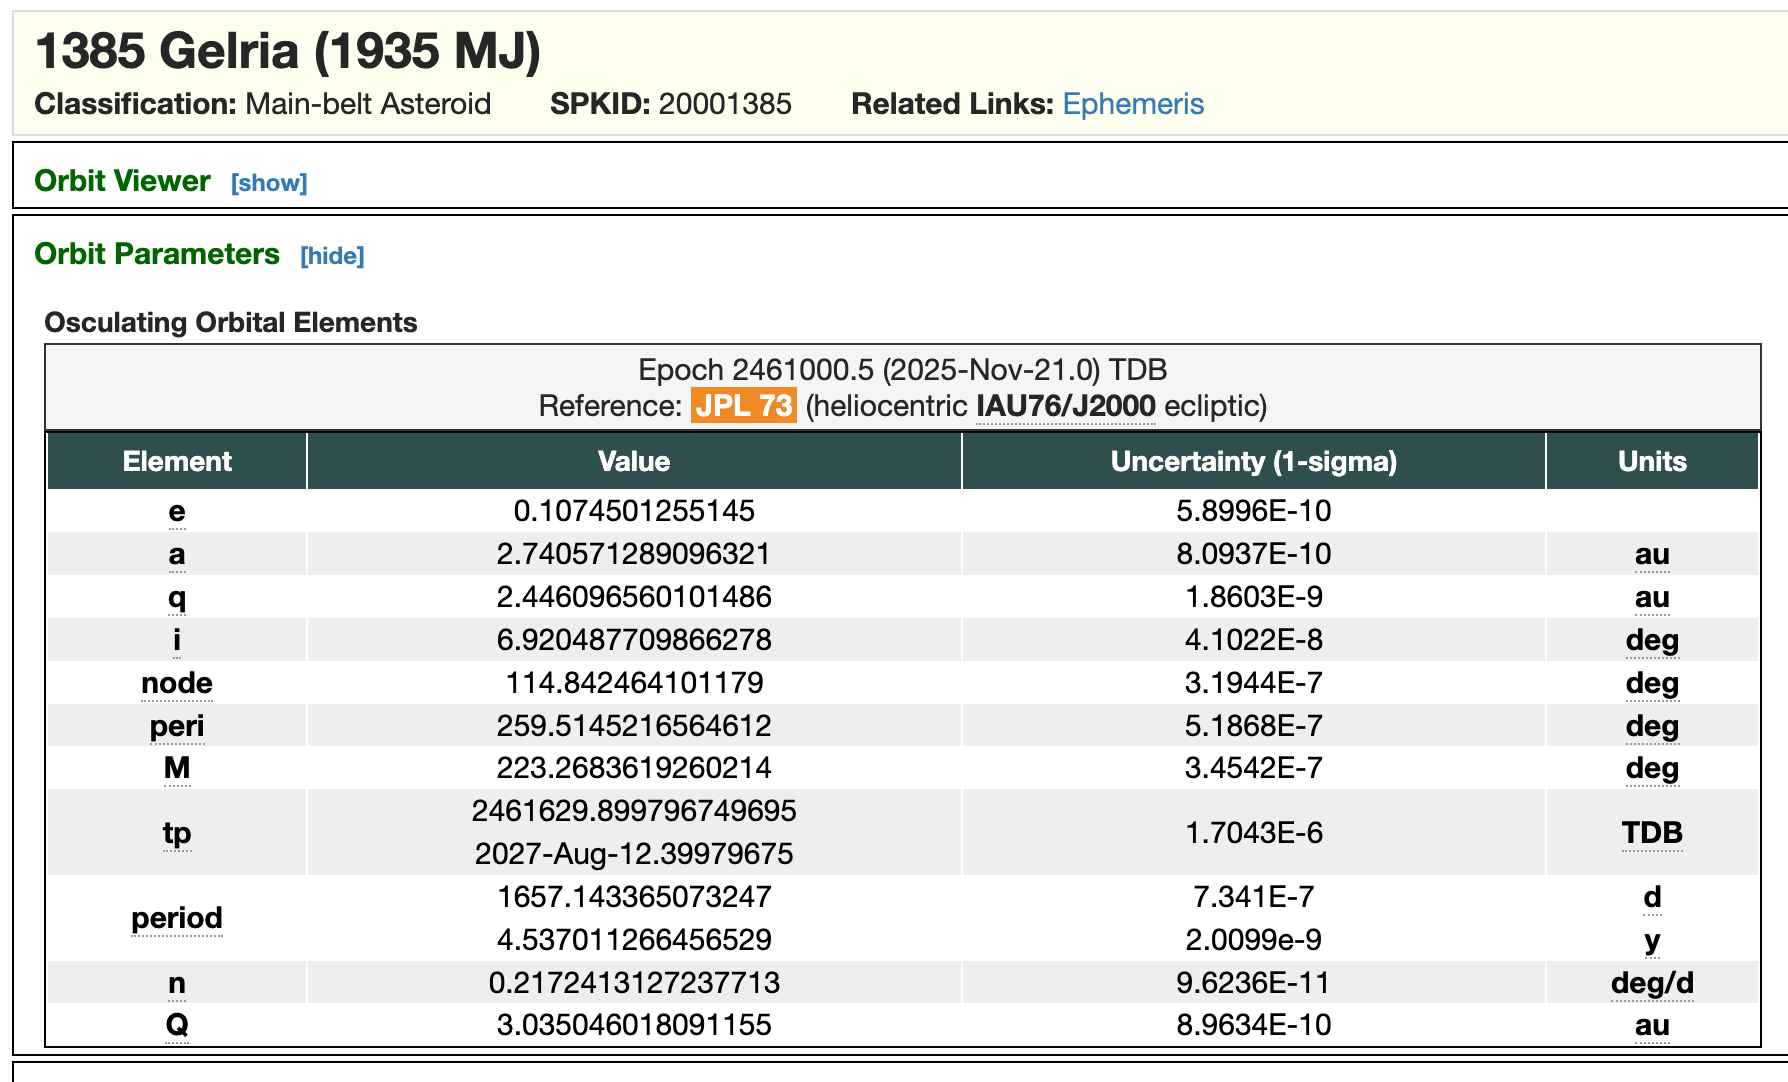
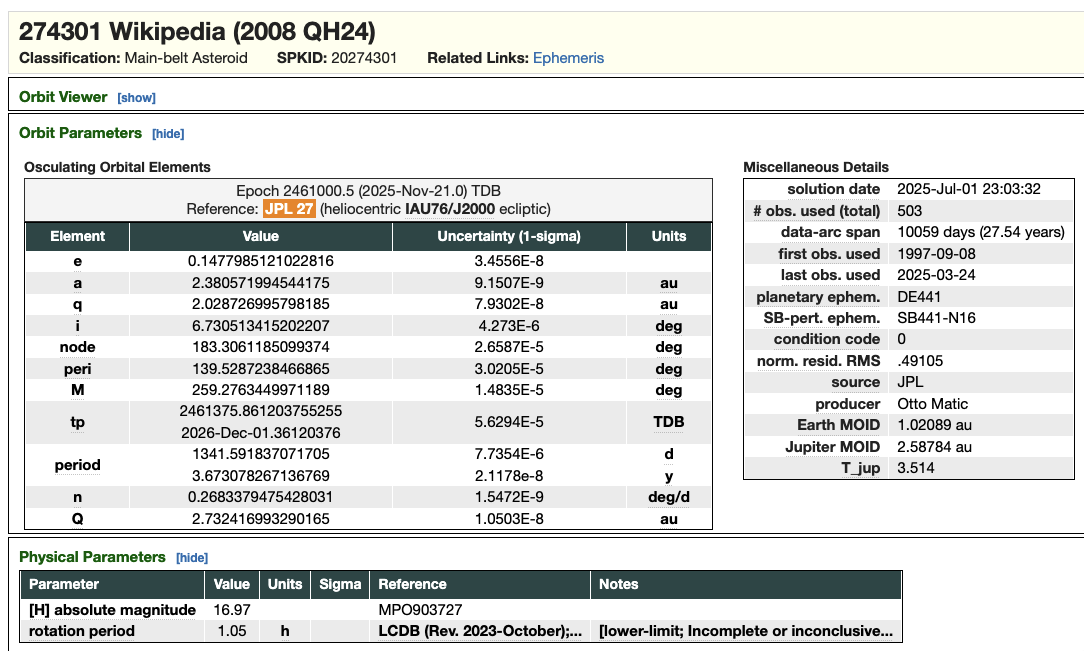

For later comparison, we'll copy some of these elements into a JAX array:

In [2]:
sbdb_helio_elements = jnp.array(
    [
        2.740571289096321,  # a
        0.1074501255145,  # e
        6.920487709866278,  # i, deg
        114.842464101179,  # Omega, deg
        259.5145216564612,  # omega, deg
        223.2683619260214,  # mean anomaly, deg
    ]
)

If we create a particle using JPL Horizons at that same epoch, its elements don't agree:

In [3]:
p = Particle.from_horizons(
    name="J35M00J", time=Time(2461000.5, format="jd", scale="tdb")
)
p.keplerian_state

KeplerianState(semi=Array([2.75126863], dtype=float64), ecc=Array([0.10606047], dtype=float64), inc=Array([6.91019815], dtype=float64), Omega=Array([114.83190949], dtype=float64), omega=Array([258.86133418], dtype=float64), nu=Array([216.28844803], dtype=float64), acceleration_func_kwargs={'c2': 29979.063823897617}, time=np.float64(2461000.5))

In [4]:
# convert the true anomaly from jorbit to mean anomaly for comparison with SBDB
jorbit_M = (
    M_from_f(p.keplerian_state.nu * jnp.pi / 180.0, p.keplerian_state.ecc[0])
    * 180.0
    / jnp.pi
)
jorbit_bary_elements = jnp.squeeze(
    jnp.array(
        [
            p.keplerian_state.semi,
            p.keplerian_state.ecc,
            p.keplerian_state.inc,
            p.keplerian_state.Omega,
            p.keplerian_state.omega,
            jorbit_M,
        ]
    )
)

jorbit_bary_elements - sbdb_helio_elements

Array([ 0.01069734, -0.00138965, -0.01028956, -0.01055461, -0.65318748,
        0.6975976 ], dtype=float64)

We can see that we're a sizeable fraction of a degree off in the angles, and that the semi-major axis and eccentricity don't agree well either. There are two primary reasons for this: first, there is a shift in position and velocity between the heliocentric and barycentric frames due to the Sun's own motion around the Solar System barycenter. Second, we use different total masses of the central body when converting between Cartesian and Keplerian states.

As a convience for converting between these frames, `jorbit` includes two helper methods: `barycentric_to_heliocentric` and `heliocentric_to_barycentric`. Note, however, that `jorbit` will always assume you're in the barycentric frame when creating
and integrating particles: these helper functions exist only to make it easier to construct barycentric states, or to compare with heliocentric elements from external sources. To keep things clear, anything that's in the heliocentric frame will be passed or returned as a dictionary; `CartesianState` and `KeplerianState` objects are always assumed to be barycentric.

In [5]:
jorbit_helio_elements = barycentric_to_heliocentric(
    state=p.keplerian_state, time=Time(2461000.5, format="jd", scale="tdb")
)
jorbit_helio_elements

{'a_helio': Array([2.74057129], dtype=float64),
 'ecc_helio': Array([0.10745013], dtype=float64),
 'inc_helio': Array([6.92048771], dtype=float64),
 'Omega_helio': Array([114.8424641], dtype=float64),
 'omega_helio': Array([259.51452162], dtype=float64),
 'nu_helio': Array([215.60565156], dtype=float64)}

In [6]:
jorbit_helio_elements_array = jnp.squeeze(
    jnp.array(
        [
            jorbit_helio_elements["a_helio"],
            jorbit_helio_elements["ecc_helio"],
            jorbit_helio_elements["inc_helio"],
            jorbit_helio_elements["Omega_helio"],
            jorbit_helio_elements["omega_helio"],
            M_from_f(
                jorbit_helio_elements["nu_helio"] * jnp.pi / 180.0,
                jorbit_helio_elements["ecc_helio"],
            )
            * 180.0
            / jnp.pi,
        ]
    )
)
jorbit_helio_elements_array - sbdb_helio_elements

Array([-1.57402358e-09,  3.59522134e-12,  1.76447390e-09,  3.55755958e-09,
       -3.15453121e-08,  3.27852348e-07], dtype=float64)

Now the agreement is much better, closer to the uncertainties provided by SBDB. Note that the remaining small difference is likely due to difference in the actual state vector used by SBDB vs. Horizons, which is where `jorbit` pulls its initial conditions from. If we query Horizons for heliocentric elements directly, we get nearly exact agreement:

In [ ]:
epoch = Time(61000.0, format="mjd", scale="tdb")

obj = Horizons(
    id="J35M00J",
    location="500@10",
    epochs=epoch.tdb.jd,
)
heliocentric_elements = obj.elements(refplane="ecliptic")
heliocentric_elements = jnp.array(
    [
        heliocentric_elements["a"],
        heliocentric_elements["e"],
        heliocentric_elements["incl"],
        heliocentric_elements["Omega"],
        heliocentric_elements["w"],
        heliocentric_elements["M"],
    ]
).T

p = Particle.from_horizons(name="J35M00J", time=epoch)
jorbit_helio = barycentric_to_heliocentric(state=p.keplerian_state, time=epoch)
jorbit_helio = jnp.squeeze(
    jnp.array(
        [
            jorbit_helio["a_helio"],
            jorbit_helio["ecc_helio"],
            jorbit_helio["inc_helio"],
            jorbit_helio["Omega_helio"],
            jorbit_helio["omega_helio"],
            M_from_f(
                jorbit_helio["nu_helio"] * jnp.pi / 180.0, jorbit_helio["ecc_helio"]
            )
            * 180.0
            / jnp.pi,
        ]
    )
)
jorbit_helio - heliocentric_elements


Array([[-1.33226763e-15,  2.77555756e-17, -6.12843110e-14,
        -4.26325641e-14,  3.41060513e-13, -3.41060513e-13]],      dtype=float64)

We can also go the other way and convert the SBDB heliocentric elements into barycentric ones for comparison with `jorbit`'s default behavior:

In [10]:
sbdb_helio_elements_dict = {
    "a_helio": sbdb_helio_elements[0],
    "ecc_helio": sbdb_helio_elements[1],
    "inc_helio": sbdb_helio_elements[2],
    "Omega_helio": sbdb_helio_elements[3],
    "omega_helio": sbdb_helio_elements[4],
    "nu_helio": kepler(
        M=sbdb_helio_elements[5] * jnp.pi / 180, ecc=sbdb_helio_elements[1]
    )
    * 180
    / jnp.pi,
}
sbdb_helio_elements_dict

{'a_helio': Array(2.74057129, dtype=float64),
 'ecc_helio': Array(0.10745013, dtype=float64),
 'inc_helio': Array(6.92048771, dtype=float64),
 'Omega_helio': Array(114.8424641, dtype=float64),
 'omega_helio': Array(259.51452166, dtype=float64),
 'nu_helio': Array(215.60565128, dtype=float64)}

In [11]:
sbdb_bary_state = heliocentric_to_barycentric(
    heliocentric_dict=sbdb_helio_elements_dict,
    time=Time(2461000.5, format="jd", scale="tdb"),
)
sbdb_bary_elements = jnp.squeeze(
    jnp.array(
        [
            sbdb_bary_state.semi,
            sbdb_bary_state.ecc,
            sbdb_bary_state.inc,
            sbdb_bary_state.Omega,
            sbdb_bary_state.omega,
            M_from_f(sbdb_bary_state.nu * jnp.pi / 180.0, sbdb_bary_state.ecc)
            * 180.0
            / jnp.pi,
        ]
    )
)
sbdb_bary_elements - jorbit_bary_elements

Array([ 1.55179514e-09, -8.90895691e-12, -1.76140080e-09, -3.09925952e-09,
        3.99490432e-08, -3.36878600e-07], dtype=float64)